<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/GRU_AE/GRU_AE_GBPUSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 147 (delta 71), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (147/147), 120.19 KiB | 5.72 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Tue Jul 20 11:10:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'GBPUSD'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'GRU_AE'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 3.9 MB/s 
     |████████████████████████████████| 133 kB 13.2 MB/s 
     |████████████████████████████████| 170 kB 12.5 MB/s 
     |████████████████████████████████| 138 kB 13.2 MB/s 
     |████████████████████████████████| 97 kB 5.1 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 62 kB 960 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'dropout': {
            'values': [0.1, 0.2, 0.3]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop']
        },
        'activation': {
            'values': ['tanh', 'relu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

     # layer 1
    model.add(GRU(units=128, return_sequences=True, input_shape=(window_len, 1), activation=config.activation))
    model.add(Dropout(config.dropout))
    # layer 2
    model.add(GRU(units=64, return_sequences=False, activation=config.activation))
    model.add(Dropout(config.dropout))
    # layer 3
    model.add(RepeatVector(window_len))
    # layer 4
    model.add(GRU(units=64, return_sequences=True, activation=config.activation))
    model.add(Dropout(config.dropout))
    # layer 5
    model.add(GRU(units=128, return_sequences=False, activation=config.activation))
    model.add(Dropout(0.1))
    # layer 6
    model.add((Dense(1)))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: feyc7szs
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_GRU_AE/sweeps/feyc7szs


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: zko7uspb with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/50
32/32 [==============================] - 37s 314ms/step - loss: 0.1958 - mean_squared_error: 0.1958 - mean_absolute_error: 0.3530 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0785
Epoch 2/50
32/32 [==============================] - 9s 269ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0754 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0700
Epoch 3/50
32/32 [==============================] - 9s 266ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0617 - val_loss: 0.0047 - val_mean_squared_error: 0.0047 - val_mean_absolute_error: 0.0542
Epoch 4/50
32/32 [==============================] - 8s 257ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0571 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0557
Epoch 5/50
32/32 [==============================] - 8s 249ms/step - loss: 0.0054 - mean_squared

wandb: Agent Starting Run: vxjyzpze with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 17s 299ms/step - loss: 0.2507 - mean_squared_error: 0.2507 - mean_absolute_error: 0.4110 - val_loss: 0.0378 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1739
Epoch 2/100
32/32 [==============================] - 8s 257ms/step - loss: 0.0315 - mean_squared_error: 0.0315 - mean_absolute_error: 0.1502 - val_loss: 0.0040 - val_mean_squared_error: 0.0040 - val_mean_absolute_error: 0.0528
Epoch 3/100
32/32 [==============================] - 9s 269ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0647 - val_loss: 0.0032 - val_mean_squared_error: 0.0032 - val_mean_absolute_error: 0.0459
Epoch 4/100
32/32 [==============================] - 8s 261ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0544 - val_loss: 0.0033 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0455
Epoch 5/100
32/32 [==============================] - 9s 273ms/step - loss: 0.0045 - mean_sq

wandb: Agent Starting Run: 6egsdn1f with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 11s 63ms/step - loss: 0.5174 - mean_squared_error: 0.5174 - mean_absolute_error: 0.5187 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0818
Epoch 2/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0324 - mean_squared_error: 0.0324 - mean_absolute_error: 0.1391 - val_loss: 0.0303 - val_mean_squared_error: 0.0303 - val_mean_absolute_error: 0.1390
Epoch 3/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0558 - mean_squared_error: 0.0558 - mean_absolute_error: 0.1889 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - val_mean_absolute_error: 0.0397
Epoch 4/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0278 - mean_squared_error: 0.0278 - mean_absolute_error: 0.1187 - val_loss: 0.0457 - val_mean_squared_error: 0.0457 - val_mean_absolute_error: 0.1609
Epoch 5/100
32/32 [==============================] - 0s 12ms/step - loss: 0.0373 - mean_squared

wandb: Agent Starting Run: uymvgqrx with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 11s 554ms/step - loss: 0.2235 - mean_squared_error: 0.2235 - mean_absolute_error: 0.3802 - val_loss: 0.0906 - val_mean_squared_error: 0.0906 - val_mean_absolute_error: 0.2266
Epoch 2/200
8/8 [==============================] - 2s 256ms/step - loss: 0.1096 - mean_squared_error: 0.1096 - mean_absolute_error: 0.2697 - val_loss: 0.0568 - val_mean_squared_error: 0.0568 - val_mean_absolute_error: 0.2148
Epoch 3/200
8/8 [==============================] - 2s 262ms/step - loss: 0.0631 - mean_squared_error: 0.0631 - mean_absolute_error: 0.2110 - val_loss: 0.0261 - val_mean_squared_error: 0.0261 - val_mean_absolute_error: 0.1323
Epoch 4/200
8/8 [==============================] - 2s 239ms/step - loss: 0.0285 - mean_squared_error: 0.0285 - mean_absolute_error: 0.1405 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0903
Epoch 5/200
8/8 [==============================] - 2s 250ms/step - loss: 0.0145 - mean_squared_erro

wandb: Agent Starting Run: psv1hw9r with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 9s 241ms/step - loss: 1.6122 - mean_squared_error: 1.6122 - mean_absolute_error: 0.9946 - val_loss: 0.2084 - val_mean_squared_error: 0.2084 - val_mean_absolute_error: 0.3896
Epoch 2/100
8/8 [==============================] - 0s 15ms/step - loss: 0.1819 - mean_squared_error: 0.1819 - mean_absolute_error: 0.3433 - val_loss: 0.0346 - val_mean_squared_error: 0.0346 - val_mean_absolute_error: 0.1610
Epoch 3/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0438 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1800 - val_loss: 0.0198 - val_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.1169
Epoch 4/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0222 - mean_squared_error: 0.0222 - mean_absolute_error: 0.1252 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0844
Epoch 5/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0445 - mean_squared_error: 0.

wandb: Agent Starting Run: u7hqopng with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 8s 110ms/step - loss: 0.1295 - mean_squared_error: 0.1295 - mean_absolute_error: 0.2716 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0907
Epoch 2/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0142 - mean_squared_error: 0.0142 - mean_absolute_error: 0.0982 - val_loss: 0.0038 - val_mean_squared_error: 0.0038 - val_mean_absolute_error: 0.0487
Epoch 3/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0579 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - val_mean_absolute_error: 0.0418
Epoch 4/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0521 - val_loss: 0.0035 - val_mean_squared_error: 0.0035 - val_mean_absolute_error: 0.0470
Epoch 5/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0047 - mean_squared

wandb: Processing terminal ouput (stdout)...
wandb: Done.


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h8iie21j with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 8s 107ms/step - loss: 1.1024 - mean_squared_error: 1.1024 - mean_absolute_error: 0.7207 - val_loss: 0.0414 - val_mean_squared_error: 0.0414 - val_mean_absolute_error: 0.1785
Epoch 2/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0415 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1669 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0749
Epoch 3/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0285 - mean_squared_error: 0.0285 - mean_absolute_error: 0.1263 - val_loss: 0.0237 - val_mean_squared_error: 0.0237 - val_mean_absolute_error: 0.1228
Epoch 4/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0220 - mean_squared_error: 0.0220 - mean_absolute_error: 0.1158 - val_loss: 0.0050 - val_mean_squared_error: 0.0050 - val_mean_absolute_error: 0.0580
Epoch 5/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0165 - mean_squared

wandb: Agent Starting Run: 41umdzz9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 9s 275ms/step - loss: 0.1512 - mean_squared_error: 0.1512 - mean_absolute_error: 0.2906 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0775
Epoch 2/200
8/8 [==============================] - 0s 18ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0843 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0815
Epoch 3/200
8/8 [==============================] - 0s 19ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - mean_absolute_error: 0.0855 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0794
Epoch 4/200
8/8 [==============================] - 0s 17ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0678 - val_loss: 0.0122 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0882
Epoch 5/200
8/8 [==============================] - 0s 16ms/step - loss: 0.0082 - mean_squared_error: 0.

wandb: Agent Starting Run: 8m7uesci with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 17s 306ms/step - loss: 0.1782 - mean_squared_error: 0.1782 - mean_absolute_error: 0.3231 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - val_mean_absolute_error: 0.0642
Epoch 2/50
32/32 [==============================] - 8s 252ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0594 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - val_mean_absolute_error: 0.0484
Epoch 3/50
32/32 [==============================] - 8s 262ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0535 - val_loss: 0.0033 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0453
Epoch 4/50
32/32 [==============================] - 9s 272ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0501 - val_loss: 0.0035 - val_mean_squared_error: 0.0035 - val_mean_absolute_error: 0.0473
Epoch 5/50
32/32 [==============================] - 9s 272ms/step - loss: 0.0037 - mean_squared

wandb: Agent Starting Run: kzhqs360 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 14s 393ms/step - loss: 0.2720 - mean_squared_error: 0.2720 - mean_absolute_error: 0.4330 - val_loss: 0.0270 - val_mean_squared_error: 0.0270 - val_mean_absolute_error: 0.1459
Epoch 2/200
16/16 [==============================] - 4s 251ms/step - loss: 0.0236 - mean_squared_error: 0.0236 - mean_absolute_error: 0.1286 - val_loss: 0.0047 - val_mean_squared_error: 0.0047 - val_mean_absolute_error: 0.0559
Epoch 3/200
16/16 [==============================] - 4s 253ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0555 - val_loss: 0.0038 - val_mean_squared_error: 0.0038 - val_mean_absolute_error: 0.0497
Epoch 4/200
16/16 [==============================] - 4s 268ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0511 - val_loss: 0.0034 - val_mean_squared_error: 0.0034 - val_mean_absolute_error: 0.0460
Epoch 5/200
16/16 [==============================] - 4s 260ms/step - loss: 0.0033 - mean_sq

wandb: Agent Starting Run: 5qjznoq3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 11s 480ms/step - loss: 0.4414 - mean_squared_error: 0.4414 - mean_absolute_error: 0.4426 - val_loss: 0.1520 - val_mean_squared_error: 0.1520 - val_mean_absolute_error: 0.3159
Epoch 2/100
8/8 [==============================] - 2s 279ms/step - loss: 0.1556 - mean_squared_error: 0.1556 - mean_absolute_error: 0.3164 - val_loss: 0.0454 - val_mean_squared_error: 0.0454 - val_mean_absolute_error: 0.1626
Epoch 3/100
8/8 [==============================] - 2s 269ms/step - loss: 0.0370 - mean_squared_error: 0.0370 - mean_absolute_error: 0.1552 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0749
Epoch 4/100
8/8 [==============================] - 2s 278ms/step - loss: 0.0175 - mean_squared_error: 0.0175 - mean_absolute_error: 0.1029 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.1019
Epoch 5/100
8/8 [==============================] - 2s 280ms/step - loss: 0.0167 - mean_squared_erro

wandb: Agent Starting Run: 410ct1dj with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 13s 374ms/step - loss: 0.2293 - mean_squared_error: 0.2293 - mean_absolute_error: 0.3835 - val_loss: 0.0183 - val_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.1192
Epoch 2/200
16/16 [==============================] - 4s 260ms/step - loss: 0.0163 - mean_squared_error: 0.0163 - mean_absolute_error: 0.1024 - val_loss: 0.0042 - val_mean_squared_error: 0.0042 - val_mean_absolute_error: 0.0516
Epoch 3/200
16/16 [==============================] - 4s 257ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0657 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0609
Epoch 4/200
16/16 [==============================] - 4s 268ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0710 - val_loss: 0.0037 - val_mean_squared_error: 0.0037 - val_mean_absolute_error: 0.0480
Epoch 5/200
16/16 [==============================] - 5s 285ms/step - loss: 0.0091 - mean_sq

wandb: Agent Starting Run: wrwel8l3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 18s 331ms/step - loss: 0.2005 - mean_squared_error: 0.2005 - mean_absolute_error: 0.3498 - val_loss: 0.0045 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0547
Epoch 2/100
32/32 [==============================] - 9s 282ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0628 - val_loss: 0.0035 - val_mean_squared_error: 0.0035 - val_mean_absolute_error: 0.0477
Epoch 3/100
32/32 [==============================] - 9s 266ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0486 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - val_mean_absolute_error: 0.0434
Epoch 4/100
32/32 [==============================] - 9s 276ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0476 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - val_mean_absolute_error: 0.0472
Epoch 5/100
32/32 [==============================] - 9s 277ms/step - loss: 0.0041 - mean_sq

wandb: Agent Starting Run: ed6g8myq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
32/32 [==============================] - 9s 81ms/step - loss: 0.1389 - mean_squared_error: 0.1389 - mean_absolute_error: 0.2645 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0587
Epoch 2/200
32/32 [==============================] - 1s 16ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - mean_absolute_error: 0.0802 - val_loss: 0.0030 - val_mean_squared_error: 0.0030 - val_mean_absolute_error: 0.0444
Epoch 3/200
32/32 [==============================] - 1s 16ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0546 - val_loss: 0.0046 - val_mean_squared_error: 0.0046 - val_mean_absolute_error: 0.0546
Epoch 4/200
32/32 [==============================] - 1s 17ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0595 - val_loss: 0.0020 - val_mean_squared_error: 0.0020 - val_mean_absolute_error: 0.0357
Epoch 5/200
32/32 [==============================] - 1s 18ms/step - loss: 0.0040 - mean_squared_

wandb: Agent Starting Run: emyhw1h2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 10s 82ms/step - loss: 0.0919 - mean_squared_error: 0.0919 - mean_absolute_error: 0.1925 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0892
Epoch 2/50
32/32 [==============================] - 1s 17ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0539 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - val_mean_absolute_error: 0.0422
Epoch 3/50
32/32 [==============================] - 1s 17ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0441 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - val_mean_absolute_error: 0.0416
Epoch 4/50
32/32 [==============================] - 1s 16ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0444 - val_loss: 0.0040 - val_mean_squared_error: 0.0040 - val_mean_absolute_error: 0.0502
Epoch 5/50
32/32 [==============================] - 1s 18ms/step - loss: 0.0053 - mean_squared_erro

wandb: Agent Starting Run: r87791wl with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 11s 527ms/step - loss: 0.1841 - mean_squared_error: 0.1841 - mean_absolute_error: 0.3406 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.1090
Epoch 2/50
8/8 [==============================] - 2s 282ms/step - loss: 0.0189 - mean_squared_error: 0.0189 - mean_absolute_error: 0.1139 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0757
Epoch 3/50
8/8 [==============================] - 2s 288ms/step - loss: 0.0175 - mean_squared_error: 0.0175 - mean_absolute_error: 0.1034 - val_loss: 0.0163 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.1059
Epoch 4/50
8/8 [==============================] - 2s 287ms/step - loss: 0.0160 - mean_squared_error: 0.0160 - mean_absolute_error: 0.0954 - val_loss: 0.0034 - val_mean_squared_error: 0.0034 - val_mean_absolute_error: 0.0471
Epoch 5/50
8/8 [==============================] - 2s 265ms/step - loss: 0.0099 - mean_squared_error: 0.

wandb: Agent Starting Run: tiundh5v with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 9s 62ms/step - loss: 0.0831 - mean_squared_error: 0.0831 - mean_absolute_error: 0.1940 - val_loss: 0.0035 - val_mean_squared_error: 0.0035 - val_mean_absolute_error: 0.0485
Epoch 2/50
32/32 [==============================] - 0s 14ms/step - loss: 0.0125 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0776 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.1077
Epoch 3/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0794 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0756
Epoch 4/50
32/32 [==============================] - 0s 14ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0699 - val_loss: 0.0032 - val_mean_squared_error: 0.0032 - val_mean_absolute_error: 0.0450
Epoch 5/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0077 - mean_squared_error

wandb: Agent Starting Run: efnwuzs6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 18s 337ms/step - loss: 0.1276 - mean_squared_error: 0.1276 - mean_absolute_error: 0.2808 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.1148
Epoch 2/100
32/32 [==============================] - 9s 266ms/step - loss: 0.0155 - mean_squared_error: 0.0155 - mean_absolute_error: 0.0977 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0724
Epoch 3/100
32/32 [==============================] - 8s 259ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0577 - val_loss: 0.0043 - val_mean_squared_error: 0.0043 - val_mean_absolute_error: 0.0523
Epoch 4/100
32/32 [==============================] - 8s 264ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0521 - val_loss: 0.0033 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0453
Epoch 5/100
32/32 [==============================] - 8s 253ms/step - loss: 0.0039 - mean_sq

wandb: Agent Starting Run: uadec3lz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 9s 113ms/step - loss: 0.1234 - mean_squared_error: 0.1234 - mean_absolute_error: 0.2516 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0896
Epoch 2/100
16/16 [==============================] - 0s 18ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0666 - val_loss: 0.0152 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.1058
Epoch 3/100
16/16 [==============================] - 0s 19ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0767 - val_loss: 0.0035 - val_mean_squared_error: 0.0035 - val_mean_absolute_error: 0.0471
Epoch 4/100
16/16 [==============================] - 0s 18ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0568 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0609
Epoch 5/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0066 - mean_squared

wandb: Agent Starting Run: 3m1zud8f with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 9s 117ms/step - loss: 0.1361 - mean_squared_error: 0.1361 - mean_absolute_error: 0.2763 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - val_mean_absolute_error: 0.0440
Epoch 2/200
16/16 [==============================] - 0s 16ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0707 - val_loss: 0.0034 - val_mean_squared_error: 0.0034 - val_mean_absolute_error: 0.0475
Epoch 3/200
16/16 [==============================] - 0s 16ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0466 - val_loss: 0.0022 - val_mean_squared_error: 0.0022 - val_mean_absolute_error: 0.0377
Epoch 4/200
16/16 [==============================] - 0s 17ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0391 - val_loss: 0.0024 - val_mean_squared_error: 0.0024 - val_mean_absolute_error: 0.0389
Epoch 5/200
16/16 [==============================] - 0s 14ms/step - loss: 0.0023 - mean_squared

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: smy96a1q with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 14s 382ms/step - loss: 0.1336 - mean_squared_error: 0.1336 - mean_absolute_error: 0.2874 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0645
Epoch 2/100
16/16 [==============================] - 5s 288ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0683 - val_loss: 0.0053 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0576
Epoch 3/100
16/16 [==============================] - 4s 272ms/step - loss: 0.0133 - mean_squared_error: 0.0133 - mean_absolute_error: 0.0922 - val_loss: 0.0031 - val_mean_squared_error: 0.0031 - val_mean_absolute_error: 0.0449
Epoch 4/100
16/16 [==============================] - 4s 277ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0695 - val_loss: 0.0045 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0567
Epoch 5/100
16/16 [==============================] - 4s 281ms/step - loss: 0.0067 - mean_sq

wandb: Processing terminal ouput (stdout)...
wandb: Done.


wandb: Agent Starting Run: p4fokfj6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 14s 374ms/step - loss: 0.1319 - mean_squared_error: 0.1319 - mean_absolute_error: 0.2835 - val_loss: 0.0551 - val_mean_squared_error: 0.0551 - val_mean_absolute_error: 0.2016
Epoch 2/50
16/16 [==============================] - 4s 235ms/step - loss: 0.0219 - mean_squared_error: 0.0219 - mean_absolute_error: 0.1030 - val_loss: 0.0075 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0669
Epoch 3/50
16/16 [==============================] - 4s 264ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0770 - val_loss: 0.0167 - val_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.1060
Epoch 4/50
16/16 [==============================] - 4s 269ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0838 - val_loss: 0.0030 - val_mean_squared_error: 0.0030 - val_mean_absolute_error: 0.0440
Epoch 5/50
16/16 [==============================] - 4s 255ms/step - loss: 0.0093 - mean_squared

wandb: Agent Starting Run: 7ctg5s90 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 13s 404ms/step - loss: 0.1770 - mean_squared_error: 0.1770 - mean_absolute_error: 0.3259 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0952
Epoch 2/100
16/16 [==============================] - 4s 268ms/step - loss: 0.0129 - mean_squared_error: 0.0129 - mean_absolute_error: 0.0932 - val_loss: 0.0038 - val_mean_squared_error: 0.0038 - val_mean_absolute_error: 0.0494
Epoch 3/100
16/16 [==============================] - 4s 269ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0705 - val_loss: 0.0032 - val_mean_squared_error: 0.0032 - val_mean_absolute_error: 0.0452
Epoch 4/100
16/16 [==============================] - 4s 273ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0629 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0870
Epoch 5/100
16/16 [==============================] - 5s 285ms/step - loss: 0.0099 - mean_sq

wandb: Agent Starting Run: 53zgv7k4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
32/32 [==============================] - 18s 323ms/step - loss: 0.1392 - mean_squared_error: 0.1392 - mean_absolute_error: 0.2712 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - val_mean_absolute_error: 0.0487
Epoch 2/200
32/32 [==============================] - 9s 269ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0672 - val_loss: 0.0050 - val_mean_squared_error: 0.0050 - val_mean_absolute_error: 0.0547
Epoch 3/200
32/32 [==============================] - 9s 276ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0643 - val_loss: 0.0038 - val_mean_squared_error: 0.0038 - val_mean_absolute_error: 0.0509
Epoch 4/200
32/32 [==============================] - 8s 258ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0526 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0607
Epoch 5/200
32/32 [==============================] - 8s 251ms/step - loss: 0.0062 - mean_sq

wandb: Agent Starting Run: d3urrqis with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 13s 364ms/step - loss: 0.1491 - mean_squared_error: 0.1491 - mean_absolute_error: 0.2939 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0601
Epoch 2/50
16/16 [==============================] - 4s 264ms/step - loss: 0.0142 - mean_squared_error: 0.0142 - mean_absolute_error: 0.0914 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0526
Epoch 3/50
16/16 [==============================] - 4s 257ms/step - loss: 0.0127 - mean_squared_error: 0.0127 - mean_absolute_error: 0.0834 - val_loss: 0.0039 - val_mean_squared_error: 0.0039 - val_mean_absolute_error: 0.0511
Epoch 4/50
16/16 [==============================] - 4s 258ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0764 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - val_mean_absolute_error: 0.1205
Epoch 5/50
16/16 [==============================] - 4s 262ms/step - loss: 0.0106 - mean_squared

wandb: Agent Starting Run: coga2ybo with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 8s 60ms/step - loss: 0.1562 - mean_squared_error: 0.1562 - mean_absolute_error: 0.2776 - val_loss: 0.0041 - val_mean_squared_error: 0.0041 - val_mean_absolute_error: 0.0520
Epoch 2/100
32/32 [==============================] - 0s 15ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0454 - val_loss: 0.0020 - val_mean_squared_error: 0.0020 - val_mean_absolute_error: 0.0358
Epoch 3/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0337 - val_loss: 0.0021 - val_mean_squared_error: 0.0021 - val_mean_absolute_error: 0.0358
Epoch 4/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0331 - val_loss: 0.0019 - val_mean_squared_error: 0.0019 - val_mean_absolute_error: 0.0347
Epoch 5/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0019 - mean_squared_

wandb: Agent Starting Run: jp649dfg with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 12s 544ms/step - loss: 0.2540 - mean_squared_error: 0.2540 - mean_absolute_error: 0.4156 - val_loss: 0.0363 - val_mean_squared_error: 0.0363 - val_mean_absolute_error: 0.1585
Epoch 2/100
8/8 [==============================] - 2s 286ms/step - loss: 0.0402 - mean_squared_error: 0.0402 - mean_absolute_error: 0.1720 - val_loss: 0.0379 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1573
Epoch 3/100
8/8 [==============================] - 2s 274ms/step - loss: 0.0267 - mean_squared_error: 0.0267 - mean_absolute_error: 0.1232 - val_loss: 0.0067 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0666
Epoch 4/100
8/8 [==============================] - 2s 276ms/step - loss: 0.0170 - mean_squared_error: 0.0170 - mean_absolute_error: 0.0997 - val_loss: 0.0197 - val_mean_squared_error: 0.0197 - val_mean_absolute_error: 0.1157
Epoch 5/100
8/8 [==============================] - 2s 276ms/step - loss: 0.0146 - mean_squared_erro

wandb: Agent Starting Run: re8uplv0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 8s 109ms/step - loss: 0.0922 - mean_squared_error: 0.0922 - mean_absolute_error: 0.2148 - val_loss: 0.0067 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0634
Epoch 2/200
16/16 [==============================] - 0s 16ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0809 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0942
Epoch 3/200
16/16 [==============================] - 0s 14ms/step - loss: 0.0172 - mean_squared_error: 0.0172 - mean_absolute_error: 0.0983 - val_loss: 0.0031 - val_mean_squared_error: 0.0031 - val_mean_absolute_error: 0.0448
Epoch 4/200
16/16 [==============================] - 0s 14ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0574 - val_loss: 0.0031 - val_mean_squared_error: 0.0031 - val_mean_absolute_error: 0.0445
Epoch 5/200
16/16 [==============================] - 0s 15ms/step - loss: 0.0088 - mean_squared

wandb: Agent Starting Run: tpv82kma with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 9s 65ms/step - loss: 0.0583 - mean_squared_error: 0.0583 - mean_absolute_error: 0.1601 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.1007
Epoch 2/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0744 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0767
Epoch 3/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0652 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0728
Epoch 4/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0530 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0854
Epoch 5/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0074 - mean_squared_error

wandb: Agent Starting Run: lzhht9kv with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 13s 376ms/step - loss: 0.1907 - mean_squared_error: 0.1907 - mean_absolute_error: 0.3553 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - val_mean_absolute_error: 0.1310
Epoch 2/100
16/16 [==============================] - 4s 274ms/step - loss: 0.0754 - mean_squared_error: 0.0754 - mean_absolute_error: 0.2145 - val_loss: 0.0202 - val_mean_squared_error: 0.0202 - val_mean_absolute_error: 0.1184
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 0.0216 - mean_squared_error: 0.0216 - mean_absolute_error: 0.1202

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 100,
    'batch_size': 32,
    'learning_rate': 0.005,
    'dropout': 0.1,
    'optimizer': 'adam',
    'activation': 'tanh'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(GRU(units=128, return_sequences=True, input_shape=(window_len, 1), activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# layer 2
model.add(GRU(units=64, return_sequences=False, activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# layer 3
model.add(RepeatVector(window_len))
# layer 4
model.add(GRU(units=64, return_sequences=True, activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# layer 5
model.add(GRU(units=128, return_sequences=False, activation=best_config['activation']))
model.add(Dropout(0.1))
# layer 6
model.add((Dense(1)))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  187137


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 30, 128)           50304     
_________________________________________________________________
dropout (Dropout)            (None, 30, 128)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 64)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 30, 64)            24960     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 64)            0

In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/100
40/40 [==============================] - 6s 10ms/step - loss: 0.1248
Epoch 2/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0019
Epoch 3/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0015
Epoch 4/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0016
Epoch 5/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0014
Epoch 6/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0019
Epoch 7/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0019
Epoch 8/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0014
Epoch 9/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0012
Epoch 10/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0010
Epoch 11/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0011
Epoch 12/100
40/40 [==============================] - 0s 10ms/step - loss: 9.7384e-04
Epoch 13/100
40/40 [=

In [20]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

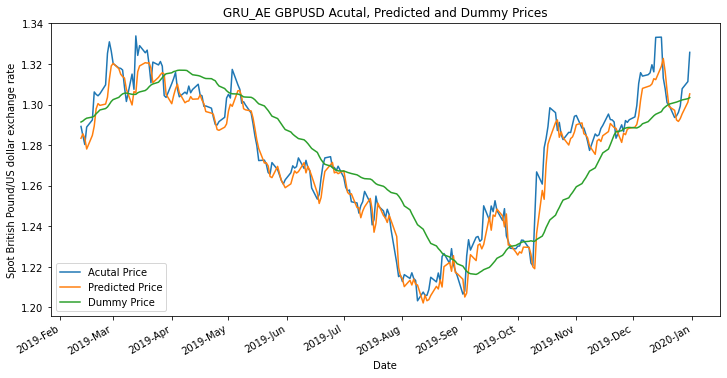

In [21]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

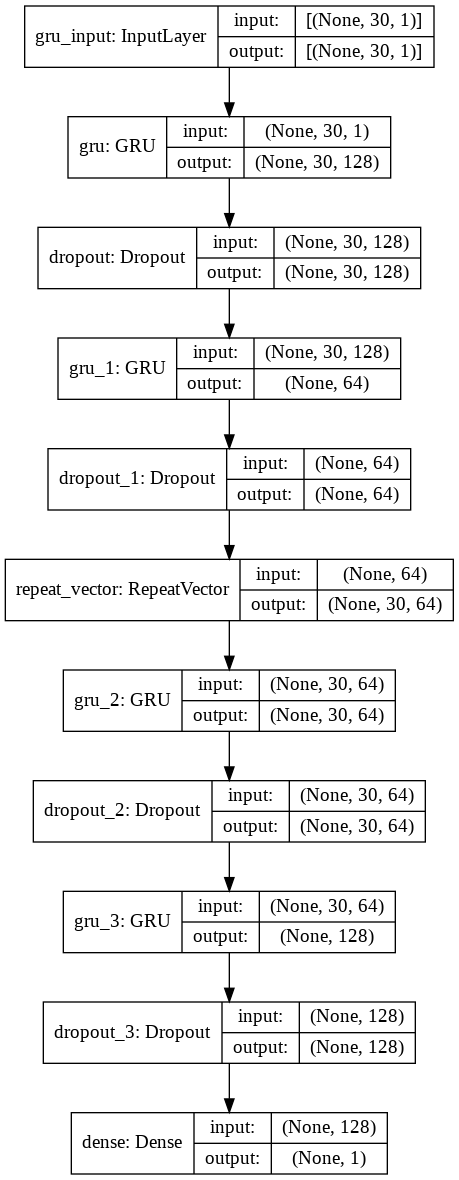

In [22]:
plot_model(model, show_shapes=True, expand_nested=True)

In [23]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.0035299325054499115
RMSE:  0.059413235103383415
MAE:  0.04352135523194508
Dummy MSE:  0.02193382943864584
Dummy RMSE:  0.14810074084435176
Dummy MAE:  0.1194927932858967


In [24]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/GRU_AE_GBPUSD/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/GRU_AE_GBPUSD/assets
